In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.time import Time
from astroplan import (Observer, is_observable, MoonSeparationConstraint,
                       AtNightConstraint, AirmassConstraint, plots, FixedTarget)

In [239]:
todays_date_local_time = Time('2020-0-15')  # Local time!
maximum_airmass = 1.5
min_moon_separation = 20 * u.deg

In [240]:
catalog = Table.read('tables/full_catalog.ecsv')

In [241]:
coords = catalog['sky_coord']

In [242]:
constraints = [AirmassConstraint(max=maximum_airmass), 
               AtNightConstraint.twilight_astronomical(), 
               MoonSeparationConstraint(min=min_moon_separation)]
apo = Observer.at_site('APO')

In [243]:
a_half_time = Time('2020-01-01 04:00') + np.arange(366) * u.day  # UTC
b_half_time = Time('2020-01-01 10:00') + np.arange(366) * u.day  # UTC

obs_a_half = is_observable(constraints, apo, coords[:, None], times=a_half_time)
obs_b_half = is_observable(constraints, apo, coords[:, None], times=b_half_time)

start, end = apo.tonight(todays_date_local_time - 1*u.day)  # Account for date difference from UTC

a_half_tonight = (start < a_half_time) & (end > a_half_time)
b_half_tonight = (start < b_half_time) & (end > b_half_time)

observable_a = catalog[np.argwhere(obs_a_half[:, a_half_tonight])[:, 0]]
observable_b = catalog[np.argwhere(obs_b_half[:, b_half_tonight])[:, 0]]

tonight_times = Time(np.linspace(start.jd, end.jd, 50), format='jd')

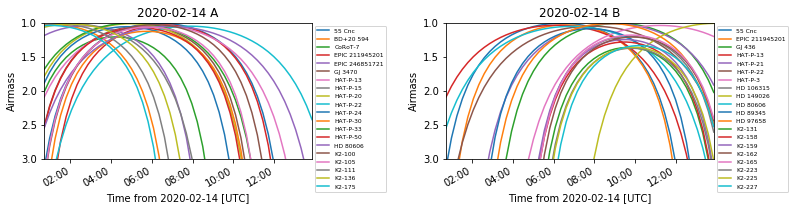

In [244]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2.5))
show_first_n = 20
plots.plot_airmass([FixedTarget(c, name=name) for c, name in 
                    zip(observable_a['sky_coord'][:show_first_n], 
                        observable_a['pl_hostname'][:show_first_n])], 
                   apo, tonight_times, ax=ax[0])
ax[0].legend(bbox_to_anchor=(1, 1, 0, 0), fontsize=6)
plots.plot_airmass([FixedTarget(c, name=name) for c, name in 
                    zip(observable_b['sky_coord'][:show_first_n], 
                        observable_b['pl_hostname'][:show_first_n])], 
                   apo, tonight_times, ax=ax[1])
fig.subplots_adjust(wspace=0.5)
ax[1].legend(bbox_to_anchor=(1, 1, 0, 0), fontsize=6)
ax[0].set_title('{0} A'.format(tonight_times[0].datetime.date()))
ax[1].set_title('{0} B'.format(tonight_times[0].datetime.date()))
fig.savefig('plots/q1.pdf', bbox_inches='tight')